In [1]:
import numpy as np
import pylab as plt
import h5py

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15


import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier

In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')

In [3]:
f.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

Donwsample the data for debugging purposes

In [4]:
howmany=int(1e5)

In [5]:
X=[]
for l in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']:
#for l in ['mtot', 'q','z']:
    X.append(f[l][:howmany])
X = np.array(X).T

y = np.array(f['det'][:howmany])


In [6]:
np.sum(y)/len(y)

0.14382

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

In [9]:
y_pred = clf.predict(X_test)

In [10]:
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
C

array([[25033,   645],
       [  673,  3649]])

In [11]:
np.sum(C.diagonal())/len(y_test)

0.9560666666666666

In [12]:
tn, fp, fn, tp = C.ravel()
print(fn)


673


In [14]:
np.sum(y_pred)

4294

In [13]:
y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_prob)

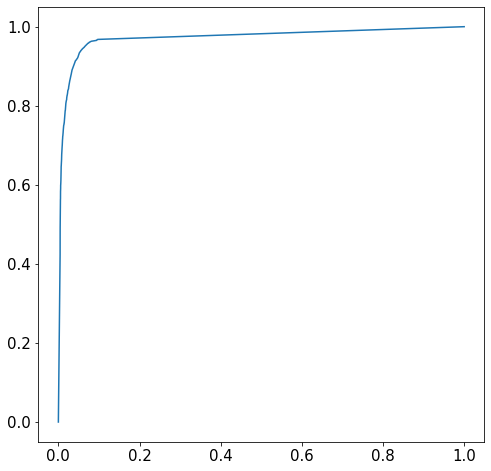

In [14]:
plt.plot(fpr, tpr)

In [15]:
completeness_test = []
contamination_test = []
completeness_train = []
contamination_train = []

md_vals = np.arange(1,20)
for md in tqdm(md_vals):
    clf = DecisionTreeClassifier(random_state=0, max_depth=md,criterion='entropy')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    C = sklearn.metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = C.ravel()
    completeness_test.append(tp/(tp+fn))
    contamination_test.append(fp/(tp+fp))

    y_pred = clf.predict(X_train)
    C = sklearn.metrics.confusion_matrix(y_train, y_pred)
    tn, fp, fn, tp = C.ravel()
    completeness_train.append(tp/(tp+fn))
    contamination_train.append(fp/(tp+fp))
    

  0%|          | 0/19 [00:00<?, ?it/s]

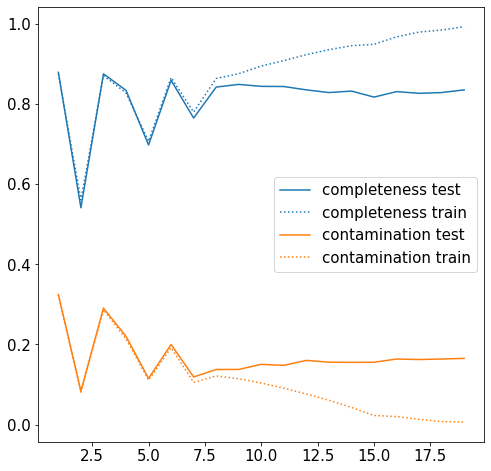

In [17]:
plt.plot(md_vals,completeness_test,label='completeness test',c='C0')
plt.plot(md_vals,completeness_train,label='completeness train',c='C0',ls='dotted')

plt.plot(md_vals,contamination_test,label='contamination test',c='C1')
plt.plot(md_vals,contamination_train,label='contamination train',c='C1',ls='dotted')
plt.legend()


From the plot above, I would say the best tree has at most 7 refinement levels.

In [18]:
np.array(completeness_test)[md_vals==7] , np.array(contamination_test)[md_vals==7]

(array([0.76515502]), array([0.11860341]))

Let's see if I can improve things with a random forest


In [19]:

clf = RandomForestClassifier(n_estimators=100, max_depth=7)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness test", tp/(tp+fn))
print("contamination test", fp/(tp+fp))

y_pred = clf.predict(X_train)
C = sklearn.metrics.confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness train", tp/(tp+fn))
print("contamination train", fp/(tp+fp))

completeness test 0.7697825080981028
contamination test 0.12077167019027484
completeness train 0.7795228628230616
contamination train 0.11007716749886519


Not much but I bumped it up by 1%. The raw fraction of correct sources is

In [20]:
y_pred = clf.predict(X_test)
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.sum(C.diagonal())/len(y_test)

0.9516